# classes and functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import sys
import os
import glob
import configparser

import h5py
import numpy as np

import scipy.integrate
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

import pickle

import corner

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def compute_integral(times, x, npts=None):
    """
    times = array of independent variable
    x = array of dependent variable
    npts = None (default to len(times)) number o fpoints to resample to integrate
    """
    
    if npts is None:
        npts = len(times)*2

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [4]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [5]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [6]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [7]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [8]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [9]:
MTSUN_SI = 4.925491025543576e-06

In [10]:
# lal.MRSUN_SI: 1476.6250614046494
MRSUN_SI = 1476.6250614046494

In [11]:
# lal.PC_SI: 3.085677581491367e+16
PC_SI = 3.085677581491367e+16

In [12]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [13]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [14]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in Mpc
    M*G/c^2 * M_sun / dist
    """
    return mtot * MRSUN_SI / (distance * 1e6*PC_SI)

In [15]:
def TaylorT3_Omega_new(t, tc, eta, M):
    """
    22 mode angular GW frequency
    equation 7 in 0901.2437
    
    3.5PN term from https://arxiv.org/pdf/gr-qc/0610122.pdf and https://arxiv.org/pdf/0907.0700.pdf
    and this too apparently https://arxiv.org/pdf/gr-qc/0406012.pdf?
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralTaylorT3.c
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralPNCoefficients.c
    
    t: time
    tc: coalescence time
    eta: symmetric mass ratio
    M: total mass (Msun)
    """
    
    Msec = Msun_to_sec(M)
    Msec = M
    
    pi2 = np.pi*np.pi
    
    c1 = eta/(5.*Msec)
    
    td = c1 * (tc - t)
    
#     td = np.sqrt(td**2 + 1)
    
    theta = td**(-1./8.) # -1./8. = -0.125 
    
    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = 1. / ( 8. * np.pi * Msec  )
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 7.43/26.88 + 1.1/3.2 * eta
    # 1.5PN
    fta3 = -3./10. * np.pi
    # 2PN
    fta4 = 1.855099/14.450688 + 5.6975/25.8048 * eta + 3.71/20.48 * eta*eta
    # 2.5PN
    fta5 = (-7.729/21.504 + 1.3/25.6 * eta) * np.pi
    # 3PN
    fta6 = -7.20817631400877/2.88412611379200 + 5.3/20.0 * pi2 + 1.07/2.80 * GAMMA  \
           + (25.302017977/4.161798144 - 4.51/20.48 * pi2) * eta \
           - 3.0913/183.5008 * eta*eta + 2.35925/17.69472 * eta*eta*eta
            
    # 3.5PN
    fta7 = (-1.88516689/4.33520640 - 9.7765/25.8048 * eta + 1.41769/12.90240 * eta*eta) * np.pi

    # 3PN log term
    ftal6 = 1.07/2.80
    

    full = theta3*ftaN * (1. \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + fta5*theta5 \
             + (fta6 + ftal6*np.log(2.*theta))*theta6 \
             + fta7*theta7)
    
    return full * 2 * np.pi # 2pi to go from freq to angular freq

In [16]:
def Hhat22_x(x, eta):
    """
    https://arxiv.org/pdf/0802.1249.pdf - eq. 9.4a
    
    here we leave the expression to depend on the post-newtonian
    parameter 'x' so that you can choose how to calculate it.
    e.g., from PN like TaylorT3 or from the model which
    is TaylorT3 + corrections
    """
    
    xarr = np.zeros(6, dtype=np.complex128)
    
    C = 0.577216 # is the Euler constant

    xarr[0] = 1.
    xarr[1] = -107./42 + 55*eta/42
    xarr[2] = 2.*np.pi
    xarr[3] = -2173./1512 - 1069.*eta/216 + 2047.*eta**2/1512
    xarr[4] = (-107*np.pi/21 - 24.*1.j*eta + 34.*np.pi*eta/21) # there is an i... not sure what to do...
    
    x5a = 27027409./646800 - 856.*C/105 + 428*1.j*np.pi/105 + 2.*np.pi**2/3
    x5b = (-278185./33264 + 41*np.pi**2/96)*eta - 20261.*eta**2/2772 + 114635.*eta**3/99792
    
    x5log =  - 428.*np.log(16*x)/105
    
    xarr[5] = (x5a) + x5b # there is an i...  not sure what to do...
    
    pre = np.sqrt(16.*np.pi/5) * 2 * eta
    
    pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3] + x**(5/2.)*xarr[4] + x**3*(xarr[5] + x5log)
    
    return pre * pn * x

In [17]:
def Hhat22_T3(t, t0, eta, M):
    """
    https://arxiv.org/pdf/0802.1249.pdf - eq. 9.4a
    Post-Newtonian expression for (l,m)=(2,2) time domain
    amplitude assuming TaylorT3 frequency evolution
    """

#     params_freq_ins={}
#     for k in PSF_freq_ins.vary_parnames:
#         params_freq_ins.update({k : PSF_freq_ins.model_evaluate(k, eta)})
#     GW22AngFreq = ff1.FreqFit.ins.ansatz(params_freq_ins, t, eta)
    
    GW22AngFreq = TaylorT3_Omega_new(t, t0, eta, M)
    OrgAngFreq = GW22AngFreq/2
    
    x = (M*OrgAngFreq)**(2./3)
    
    return Hhat22_x(x, eta)

In [18]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [19]:
class SingleModeNRWaveform(object):
    def __init__(self, nrfile, ell, mm, npts, t1=None, t2=None):

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_lm_mode(self.nrfile, ell, mm, self.npts)


    def get_lm_mode(self, nrfile, ell, mm, npts):
        
        if '.h5' in nrfile:
            f = h5py.File(nrfile, 'r')

            self.q = f.attrs['mass1']/f.attrs['mass2']
            self.eta = f.attrs['eta']

            amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
            amp_x = amp_tmp['X'].value
            amp_y = amp_tmp['Y'].value

            phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
            phase_x = phase_tmp['X'].value
            phase_y = phase_tmp['Y'].value

            f.close()
        else:
            # bam
            self.sim_dir = os.path.dirname(nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
            # strict=False because of DuplicateSectionError
            config = configparser.ConfigParser(strict=False)

            config.read(self.bbh_file)
            mass1_tmp = float(config['metadata']['mass1'])
            mass2_tmp = float(config['metadata']['mass2'])
            self.initial_sep = float(config['metadata']['initial-separation'])

            if mass1_tmp >= mass2_tmp:
                mass1 = mass1_tmp
                mass2 = mass2_tmp
            else:
                mass1 = mass2_tmp
                mass2 = mass1_tmp


            self.mass1 = mass1
            self.mass2 = mass2
            self.mtot = self.mass1 + self.mass2
            self.q = self.mass1 / self.mass2
            self.eta = self.mass1 * self.mass2 / (self.mtot)**2.
            
            times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

            # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
            hlm = re_hlm - 1.j * im_hlm
            
            amp_x = times
            amp_y = np.abs(hlm)

            phase_x = times
            phase_y = np.unwrap(np.angle(hlm))
            
            
        # shift so that amp peak is at t=0 - will need to be more careful with HMs
        amp_peak_idx = amp_y.argmax()
        amp_peak_time = amp_x[amp_peak_idx]
        amp_x = amp_x - amp_peak_time
        phase_x = phase_x - amp_peak_time
            

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        if self.t1 is None:
            self.t1 = max(amp_x[0], phase_x[0])
        if self.t2 is None:
            self.t2 = min(amp_x[-1], phase_x[-1])
            
        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [20]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.2f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        # index of maximum
        max_idx_hlm = self.hlm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_hlm = self.nrdata.times[max_idx_hlm]
        
        self.times_hlm = self.nrdata.times - self.time_at_max_idx_hlm
        

        # news
        newslmre = ihlmre.derivative()(self.times_hlm)
        newslmim = ihlmim.derivative()(self.times_hlm)

        self.newslm = newslmre - 1.j*newslmim
        
        self.newslm_amp = np.abs(self.newslm)
        
        # index of maximum
        max_idx_news = self.newslm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_news = self.nrdata.times[max_idx_news]
        
        self.times_news = self.nrdata.times - self.time_at_max_idx_news
        
        self.newslm_phase = np.unwrap(np.angle(self.newslm))
        i_newslm_phase = IUS(self.times_news, self.newslm_phase)
        self.newslm_ang_freq = i_newslm_phase.derivative()(self.times_news)
        
        
        
        # psi4
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

In [21]:
# # get data
# nrfiles = dict(
#     q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
#     q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
#     q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
#     q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
#     q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
#     q18="/Users/spx8sk/work/data/q18a0a0c025_144/h3col.r7.l5.l2.m2"
# )

In [22]:
# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5"
)

In [23]:
ell = 2
mm = 2

# npts_time = 1000*6
npts_time = 1000*4
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
# t1=-600
t1=-3100
# t1=-1000
# t1=-800
t2=60


In [24]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [25]:
for k in psi4s.keys():
    print("{} = {}".format(k, 1./psi4s[k].fdamp/2/np.pi))

q1 = 11.706422641558191
q2 = 11.554740530290251
q4 = 11.36516841490208
q5 = 11.32930696199893
q10 = 11.272552160962043
q18 = 11.255711435422901


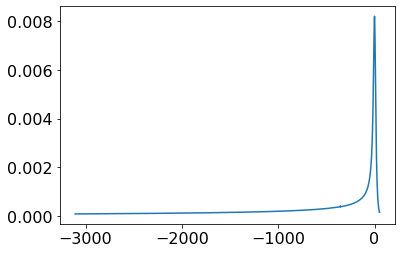

In [26]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_amp)

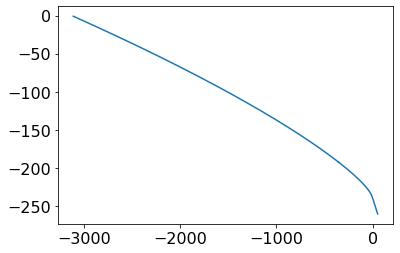

In [27]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_phase)

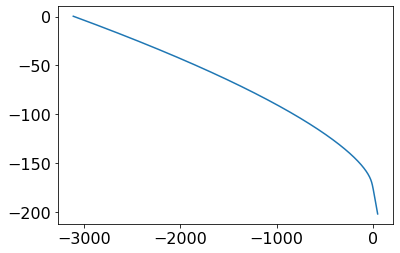

In [28]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

Text(0.5, 1.0, '$|h|(t)$')

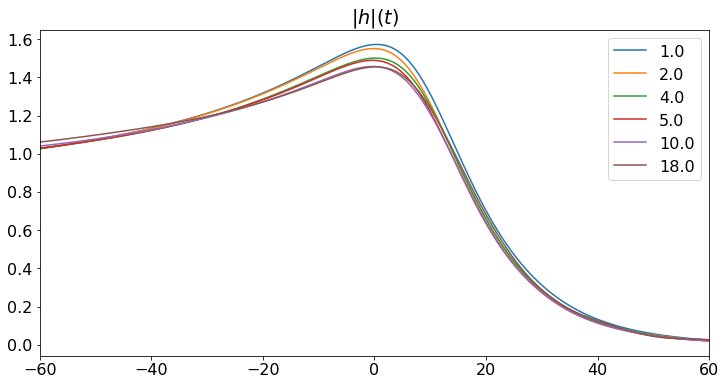

In [29]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
#     plt.plot(psi4s[k].times, psi4s[k].hlm_amp, label=psi4s[k].q)
plt.legend()
plt.xlim(-60,60)
# plt.ylim(0.2, 1.6)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|N|(t)$')

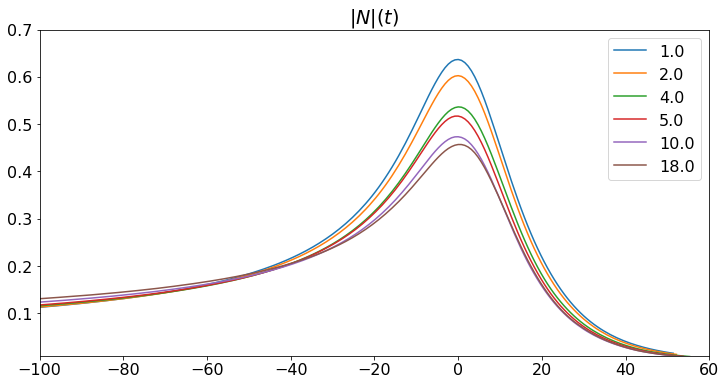

In [30]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.7)
# plt.yscale('log')
plt.title(r'$|N|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

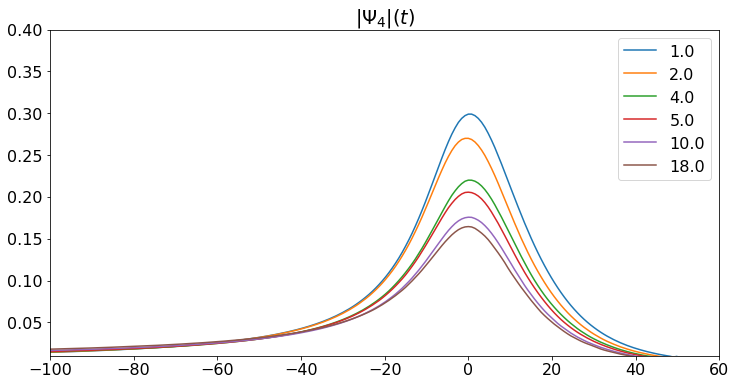

In [31]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.4)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $h$')

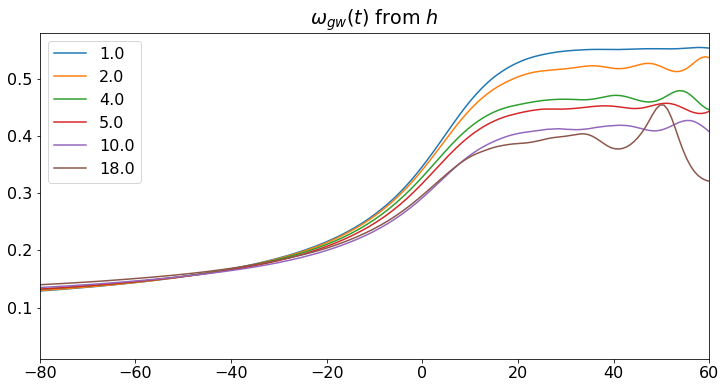

In [32]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $h$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from News')

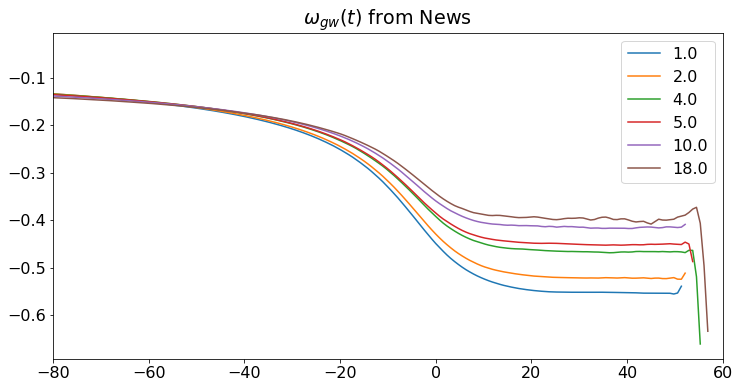

In [33]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from News')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

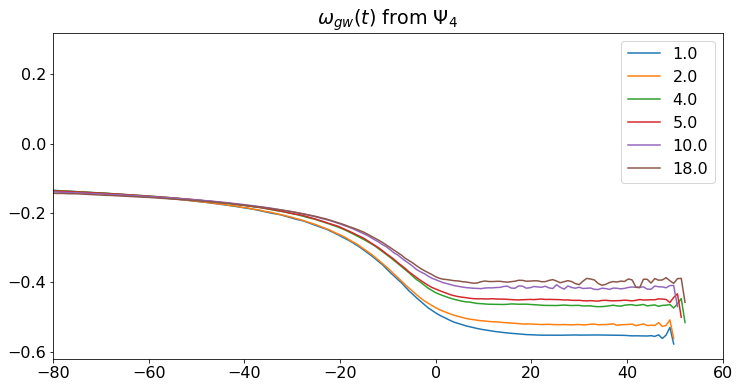

In [34]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

Text(0.5, 1.0, 'q = 18.0')

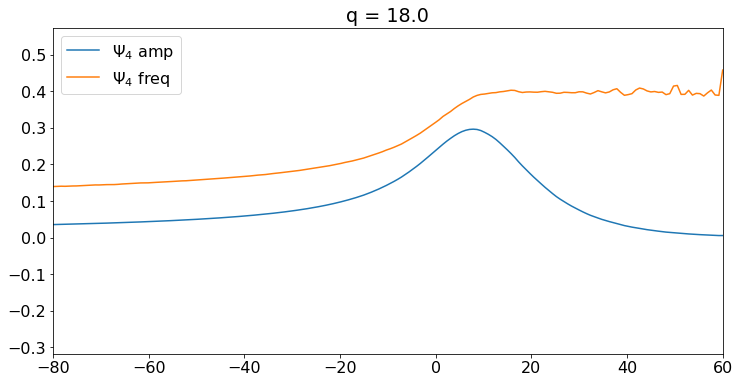

In [35]:
# compare psi4_amp and freq
k = 'q18'

plt.figure(figsize=(12, 6))
plt.plot(psi4s[k].nrdata.times, psi4s[k].psi4lm_amp / psi4s[k].eta * 1.8, label='$\Psi_4$ amp')
plt.plot(psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq, label='$\Psi_4$ freq')
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'q = {}'.format(psi4s[k].q))

# generate EOB waveforms

In [98]:
def gen_eob_wf(q, mmtot=50):

    mm1 = mass1_from_mtotal_eta(mmtot, phenom.eta_from_q(q))
    mm2 = mass2_from_mtotal_eta(mmtot, phenom.eta_from_q(q))

    hp, hc = waveform.get_td_waveform(approximant='SEOBNRv4', mass1=mm1, mass2=mm2, f_lower=14, delta_t=1./4096/2/2)
    amp = waveform.amplitude_from_polarizations(hp, hc)
    freq = waveform.frequency_from_polarizations(hp, hc)
    phase = waveform.phase_from_polarizations(hp, hc)

    tM = phenom.StoM(amp.sample_times, mmtot)
    fM = phenom.HztoMf(freq.numpy(), mmtot)
    fM = np.concatenate((fM[:],[fM[-1]]))
    fM *= 2*np.pi


    # to go from polarisation to hlm modes divide by amp prefactor and Ylm
    amp = amp.numpy() / td_amp_scale(mmtot, 1) / np.abs(lal.SpinWeightedSphericalHarmonic(0, 0, -2, 2, 2))
    
    
    # index of maximum
    max_idx = amp.argmax()
    # time of maximum
    time_at_max_idx = tM[max_idx]

    tM = tM - time_at_max_idx
    
    return tM, fM, amp, phase, q, eta_from_q(q)

In [542]:
import lal
from pycbc import waveform

# qs_for_eob = [psi4s[k].q for k in psi4s.keys()]
# qs_for_eob.append(30)

qs_for_eob = phenom.q_from_eta(np.linspace(0.25, eta_from_q(20), 6.))

eobwfs = {}
for q in qs_for_eob:
    k = "q{:.2f}".format(q)
    
    print("generating case: {:.2f}".format(q))
    
    mmtot = 50
    
    tM, fM, amp, phase, q, eta = gen_eob_wf(q=q, mmtot=mmtot)
    
    eobwfs.update({
        k:{}
    })
    
    eobwfs[k].update({
        't':tM,
        'omf':fM,
        'amp':amp,
        'phase':phase,
        'q':q,
        'eta':eta_from_q(q)
    })

generating case: 1.00
generating case: 2.36
generating case: 3.68
generating case: 5.69
generating case: 9.48
generating case: 20.00


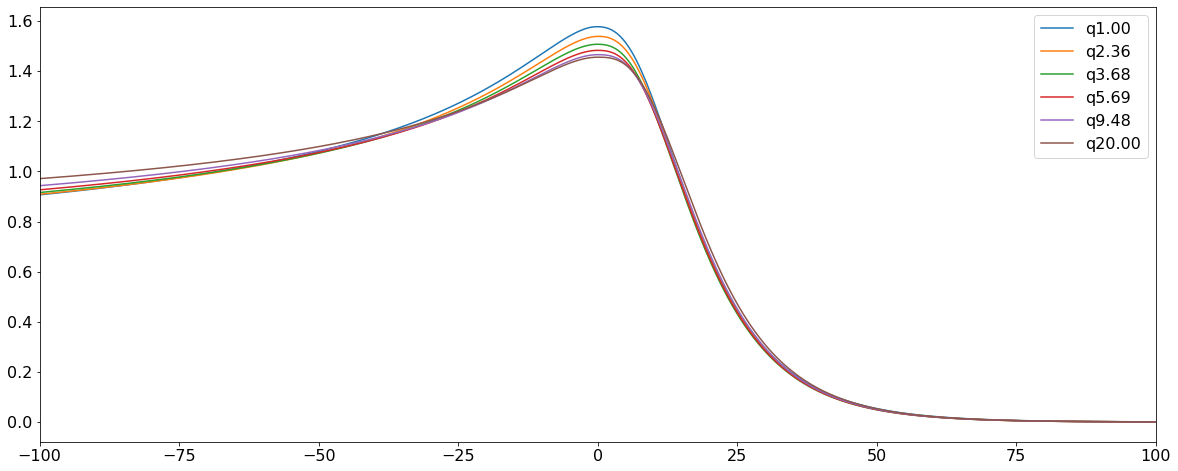

In [543]:
plt.figure(figsize=(20,8))
for k in eobwfs.keys():
    plt.plot(eobwfs[k]['t'], eobwfs[k]['amp'] / eobwfs[k]['eta'], label=k)
plt.xlim(-100,100)
plt.legend()
plt.show()
plt.close()

In [544]:
plt.figure(figsize=(20,8))
for k in eobwfs.keys():
    plt.plot(eobwfs[k]['t'], eobwfs[k]['omf'], label=k)
# plt.xlim(-3000,100)
plt.xlim(-100,100)
plt.ylim(0.01,0.6)
# plt.yscale('log')
plt.legend()
plt.show()
plt.close()

# frequency model classes

In [545]:
def freq_ins_model(t, eta, params):
    """
    this is the frequency inspiral ansatz.
    I needed an separate function so that I could use it in the amplitude inspiral model
    """
    
#     tc = params['tc']
    tc = 100
    b = params['b']
    c = params['c']
    d = params['d']
    M = 1
    
    tau = eta * (tc - t) / (5*M)
    model = (TaylorT3_Omega_new(t, tc, eta, M) + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.))
#     model = (TaylorT3_Omega_new(t, tc, eta, M) + b*tau**(-9./8.) + c*tau**(-10./8.))
    
    return model

In [546]:
class Model_Freq_Ins(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t, eta=None):
        
        if eta is None:
            eta = self.Psi4.eta
        
#         tc = params['tc']
#         b = params['b']
#         c = params['c']
#         d = params['d']
#         M = 1
        
#         tau = eta * (tc - t) / (5*M)
#         model = (TaylorT3_Omega_new(t, tc, eta, M) + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.))
        
        model = freq_ins_model(t, eta, params)
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data

    def fit(self, t1=-3000, t2=-450):
#     def fit(self, t1=-2000, t2=-450):
#     def fit(self, t1=-900, t2=-450):
#     def fit(self, t1=-1000, t2=-300):
#     def fit(self, t1=-1000, t2=-20):
#     def fit(self, t1=-600, t2=-20):
#     def fit(self, t1=-400, t2=-20):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
#         params.add('tc', value=20., min=-600, max=1000)
#         params.add('tc', value=30., min=10, max=300)
        params.add('tc', value=100., min=10, max=300, vary=False)
        
        params.add('b', value=0, min=-300, max=300, vary=True)
        params.add('c', value=0., min=-2000, max=2000, vary=True)
        params.add('d', value=0., min=-2000, max=2000, vary=True)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [547]:
class Model_Freq_Int(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
#         a2 = params['a2']
#         a3 = params['a3']
        
#         model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2 + a2 / (t - tp)**3 + a3 / (t - tp)**4
#         model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp)
#         model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) +  a1 * (t - tp)
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t-tp) + a1
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
#     def fit(self, t1=-60, t2=-5):
#     def fit(self, t1=-500, t2=-5):
    def fit(self, t1=-600, t2=-1):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tdamp', value=20., min=-1000, max=1000)
        params.add('tp', value=20, min=-300, max=300)
        params.add('lor_amp', value=20., min=-6000, max=6000)
        params.add('a0', value=0., min=-2000, max=200, vary=True)
        params.add('a1', value=0., min=-4000, max=8000, vary=True)
#         params.add('a2', value=0., min=-200, max=800, vary=False)
#         params.add('a3', value=0., min=-200, max=800, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [548]:
class Model_Freq_Int_new(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        tp = params['tp']
        
#         model = a + b*(tp-t) + c/(tp-t)**2 + d/(tp-t)
        
#         model = a*np.exp(-b*(tp-t)) + c + d/(tp-t)

#         model = a + b/(tp-t) + c*(tp-t) + d/(tp-t)**2
    
#         model = a2 + a3/(tp-t) #+ a1*(tp-t) + a0*(tp-t)**2
        
        model = (a0 * np.sqrt(a1)) / ( (tp-t)**2 + a1**2 ) + a2 / (tp-t) + a3

#         model = c + d/(t) + b*(t) + a*(t)**2
#         model = a + b*np.log((tp-t)) + d/(tp-t)
    
#         model = a*np.exp(c*(t))
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
#     def fit(self, t1=-60, t2=-5):
#     def fit(self, t1=-500, t2=-5):
    def fit(self, t1=-600, t2=-1):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tp', value=20., min=0, max=70)
        params.add('a0', value=1., min=-300, max=300)
        params.add('a1', value=2, min=1e-2, max=600)
        params.add('a2', value=3., min=-1000, max=100)
        params.add('a3', value=4., min=-2000, max=4000)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [549]:
# example_fit = Model_Freq_Int_new(psi4s['q1'])
# example_fit = Model_Freq_Int_new(psi4s['q5'])
# example_fit = Model_Freq_Int_new(psi4s['q10'])
example_fit = Model_Freq_Int_new(psi4s['q18'])

In [550]:
# example_fit.Model_Freq_Ins_Int=-30)
# example_fit.fit(t1=-600, t2=-1) # int
# example_fit.fit(t1=-1000, t2=-300) # ins
# example_fit.fit(t1=-900, t2=-300)
# example_fit.fit(t1=-3000, t2=50)
example_fit.fit(t1=-300, t2=-5)
example_fit.plot_result()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 230
    # data points      = 373
    # variables        = 5
    chi-square         = 8.5630e-06
    reduced chi-square = 2.3269e-08
    Akaike info crit   = -6550.93706
    Bayesian info crit = -6531.32917
[[Variables]]
    tp:  22.1832966 +/- 0.07914200 (0.36%) (init = 20)
    a0:  232.313206 +/- 15.6194189 (6.72%) (init = 1)
    a1:  411.942802 +/- 11.4122804 (2.77%) (init = 2)
    a2:  4.26938663 +/- 0.01517055 (0.36%) (init = 3)
    a3:  0.07112152 +/- 8.6050e-04 (1.21%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a3) = -0.999
    C(a0, a1) =  0.996
    C(a1, a3) = -0.992
    C(tp, a2) =  0.985
    C(a1, a2) =  0.821
    C(a0, a2) =  0.771
    C(a2, a3) = -0.761
    C(tp, a1) =  0.752
    C(tp, a0) =  0.700
    C(tp, a3) = -0.691


# try some inbuilt functions

In [551]:
def get_fit_data(data, t1, t2):
    if type(data) == Psi4:
        x = data.times_hlm
        y = data.hlm_ang_freq
        eta = data.eta
    else:
        x = data['t']
        y = data['omf']
        eta = data['eta']
        
    mask = (x > t1) & (x < t2)
    x = x[mask]
    y = y[mask]
    
    return x, y, eta

In [552]:
k='q1'
# k='q5'
# k='q18'

t1=-3000
t2=60

fit_times, fit_data, eta = get_fit_data(psi4s[k], t1, t2)
# fit_times, fit_data, eta = get_fit_data(eobwfs[k], t1, t2)

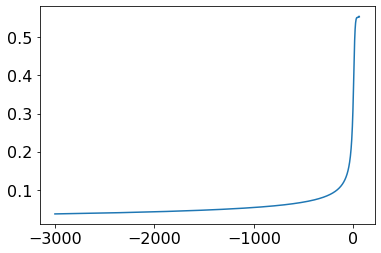

In [553]:
plt.figure()
plt.plot(fit_times, fit_data)
# plt.xscale('log')
# plt.yscale('log')

## make the inspiral model

In [584]:
from lmfit.models import Model
def ins(x, eta, b=0, c=0, d=0, tc=100):
    M = 1
    
    tau = eta * (tc - x) / (5*M)
#     model = TaylorT3_Omega_new(x, tc, eta, M) + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.)
    model = TaylorT3_Omega_new(x, tc, eta, M) * (1 + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.))
#     model = TaylorT3_Omega_new(x, tc, eta, M) * (1 + b*tau**(-8./8.) + c*tau**(-9./8.) + d*tau**(-10./8.))

    return model

In [585]:
# 

In [586]:
#https://lmfit.github.io/lmfit-py/builtin_models.html#exponential-and-power-law-models
from lmfit.models import LinearModel, StepModel

In [587]:
def fit_ins(data, k, t1, t2):

    x, y, eta = get_fit_data(data[k], t1, t2)
    
    # step_mod = StepModel(form='arctan', prefix='step_')
    # step_mod = StepModel(form='atan', prefix='step_')
    # line_mod = LinearModel(prefix='line_')

    ins_mod = Model(ins, prefix='ins_')

    # rd_mod = ExpressionModel('rd(x, x0, kappa, b, om_f, offset)', init_script=script,
    #                       independent_vars=['x'])
    # rd_mod = Model(rd, prefix='rd_')

    # pars = line_mod.make_params(intercept=y.min(), slope=0)

    pars = ins_mod.make_params(eta=eta, tc=40, b=0, c=0, d=0)
    # pars += ins_mod.make_params(eta=eta, tc=100, b=0, c=0, d=0)

    # pars += step_mod.guess(y, x=x, center=2.5, sigma=1./(psi4s[k].fdamp*2*np.pi))

    pars['ins_eta'].vary=False

#     pars['ins_tc'].vary=False

    # pars['ins_tc'].min = -10
    # pars['ins_tc'].max = 100

    # pars['ins_b'].vary=False
    # pars['ins_c'].vary=False
#     pars['ins_d'].vary=False
#     pars['ins_e'].vary=False

    # pars += rd_mod.make_params(x0=1, kappa=0.5, b=1./(psi4s[k].fdamp*2*np.pi), om_f=(psi4s[k].fring*2*np.pi), offset=0.35)

    # pars['step_center'].max=0
    # pars['step_center'].min=-10


    # pars['step_sigma'].vary=False
    # pars['rd_kappa'].vary=False
    # pars['rd_b'].vary=False
    # pars['rd_om_f'].vary=False
    # pars['rd_offset'].vary=False

    # mod = step_mod + line_mod
    # mod = step_mod + line_mod + ins_mod
    mod = ins_mod
    # mod = ins_mod + step_mod
    # mod = ins_mod + line_mod
    # mod = step_mod + ins_mod
    # mod += rd_mod
    out = mod.fit(y, pars, x=x)

    print(out.fit_report(min_correl=0.25))

    ins_int_out = out

    out.plot_fit()

    plt.figure()
    out.plot_residuals()

    plt.figure()
    plt.plot(x, y, 'b')
    plt.plot(x, out.init_fit, 'k--', label='initial fit')
    plt.plot(x, out.best_fit, 'r--', label='best fit')
    plt.legend(loc='best')
    plt.show()
    plt.close()


    plt.figure()
    plt.plot(x, 100*(y-out.best_fit)/y )
    plt.title("% error")
    # plt.xlim(-100,10)
    plt.show()
    plt.close()
    
    return out

working q1.00



[[Model]]
    Model(ins, prefix='ins_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 44792
    # variables        = 4
    chi-square         = 4.6900e-10
    reduced chi-square = 1.0472e-14
    Akaike info crit   = -1441855.80
    Bayesian info crit = -1441820.96
[[Variables]]
    ins_eta:  0.25 (fixed)
    ins_b:    17.5598919 +/- 0.57107457 (3.25%) (init = 0)
    ins_c:   -32.9405060 +/- 1.28387205 (3.90%) (init = 0)
    ins_d:    20.8393365 +/- 0.93159578 (4.47%) (init = 0)
    ins_tc:   7.45362902 +/- 4.52104491 (60.66%) (init = 40)
[[Correlations]] (unreported correlations are < 0.250)
    C(ins_c, ins_d)  = -1.000
    C(ins_b, ins_c)  = -1.000
    C(ins_b, ins_tc) =  1.000
    C(ins_b, ins_d)  =  1.000
    C(ins_c, ins_tc) = -1.000
    C(ins_d, ins_tc) =  1.000


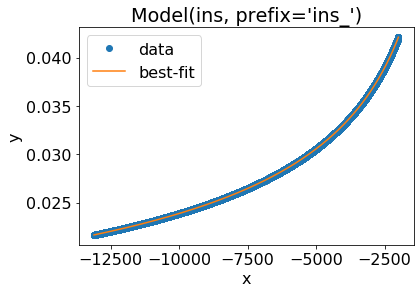

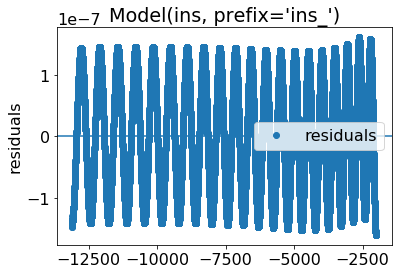

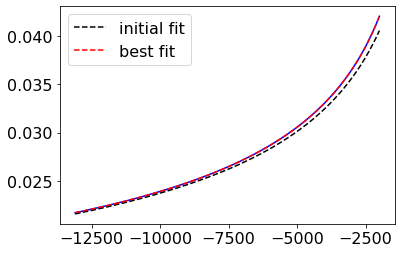

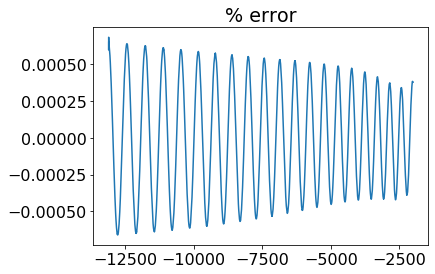

working q2.36



[[Model]]
    Model(ins, prefix='ins_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 54318
    # variables        = 4
    chi-square         = 2.4779e-10
    reduced chi-square = 4.5621e-15
    Akaike info crit   = -1793630.07
    Bayesian info crit = -1793594.46
[[Variables]]
    ins_eta:  0.2090703 (fixed)
    ins_b:    16.5421871 +/- 0.46102141 (2.79%) (init = 0)
    ins_c:   -29.5913827 +/- 1.03571948 (3.50%) (init = 0)
    ins_d:    18.7822457 +/- 0.74595753 (3.97%) (init = 0)
    ins_tc:   17.2539991 +/- 4.36025686 (25.27%) (init = 40)
[[Correlations]] (unreported correlations are < 0.250)
    C(ins_c, ins_d)  = -1.000
    C(ins_b, ins_c)  = -1.000
    C(ins_b, ins_tc) =  1.000
    C(ins_b, ins_d)  =  1.000
    C(ins_c, ins_tc) = -1.000
    C(ins_d, ins_tc) =  1.000


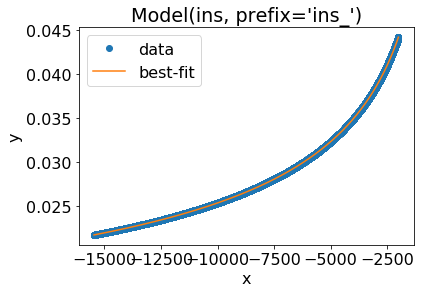

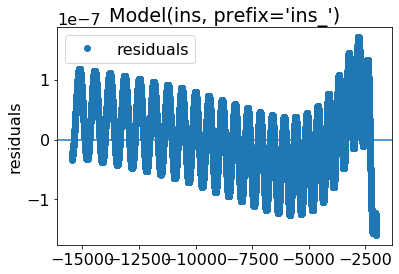

working q3.68



[[Model]]
    Model(ins, prefix='ins_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 169
    # data points      = 68497
    # variables        = 4
    chi-square         = 1.6020e-09
    reduced chi-square = 2.3389e-14
    Akaike info crit   = -2149877.89
    Bayesian info crit = -2149841.36
[[Variables]]
    ins_eta:  0.1681406 (fixed)
    ins_b:    14.9208379 +/- 0.77805496 (5.21%) (init = 0)
    ins_c:   -25.2834742 +/- 1.73002575 (6.84%) (init = 0)
    ins_d:    16.2740558 +/- 1.22181069 (7.51%) (init = 0)
    ins_tc:   19.3572491 +/- 9.22688134 (47.67%) (init = 40)
[[Correlations]] (unreported correlations are < 0.250)
    C(ins_c, ins_d)  = -1.000
    C(ins_b, ins_c)  = -1.000
    C(ins_b, ins_tc) =  1.000
    C(ins_b, ins_d)  =  1.000
    C(ins_c, ins_tc) = -1.000
    C(ins_d, ins_tc) =  1.000


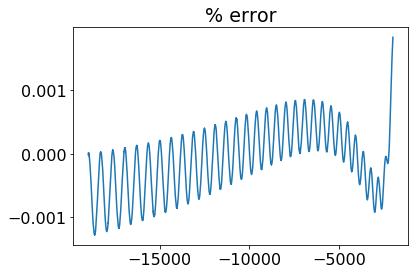

working q5.69



[[Model]]
    Model(ins, prefix='ins_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 168
    # data points      = 91797
    # variables        = 4
    chi-square         = 1.0890e-08
    reduced chi-square = 1.1864e-13
    Akaike info crit   = -2732123.43
    Bayesian info crit = -2732085.72
[[Variables]]
    ins_eta:  0.1272109 (fixed)
    ins_b:    14.0098048 +/- 1.64225508 (11.72%) (init = 0)
    ins_c:   -23.2476070 +/- 3.63506721 (15.64%) (init = 0)
    ins_d:    15.8373471 +/- 2.53266132 (15.99%) (init = 0)
    ins_tc:   29.4507417 +/- 25.7960996 (87.59%) (init = 40)
[[Correlations]] (unreported correlations are < 0.250)
    C(ins_c, ins_d)  = -1.000
    C(ins_b, ins_c)  = -1.000
    C(ins_b, ins_tc) =  1.000
    C(ins_b, ins_d)  =  1.000
    C(ins_c, ins_tc) = -1.000
    C(ins_d, ins_tc) =  1.000


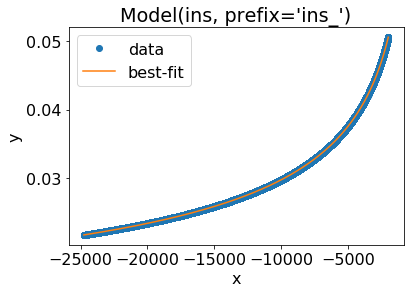

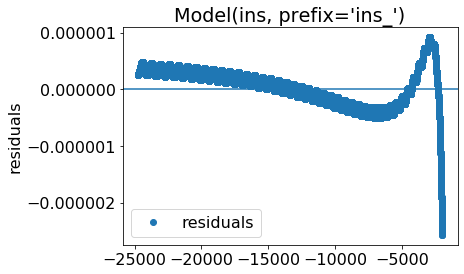

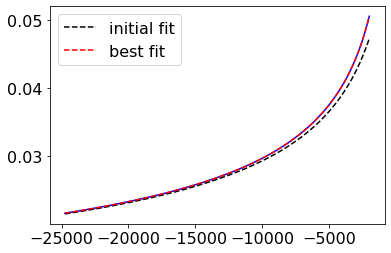

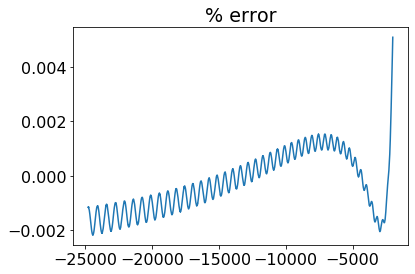

working q9.48



[[Model]]
    Model(ins, prefix='ins_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 116
    # data points      = 137203
    # variables        = 4
    chi-square         = 1.6202e-07
    reduced chi-square = 1.1809e-12
    Akaike info crit   = -3768239.71
    Bayesian info crit = -3768200.39
[[Variables]]
    ins_eta:  0.08628118 (fixed)
    ins_b:    15.5136647 +/- 0.55071285 (3.55%) (init = 0)
    ins_c:   -28.0304508 +/- 1.24299987 (4.43%) (init = 0)
    ins_d:    20.9734439 +/- 0.87805891 (4.19%) (init = 0)
    ins_tc:   83.7386989 +/- 12.4377873 (14.85%) (init = 40)
[[Correlations]] (unreported correlations are < 0.250)
    C(ins_c, ins_d)  = -1.000
    C(ins_b, ins_c)  = -1.000
    C(ins_b, ins_d)  =  1.000
    C(ins_b, ins_tc) =  1.000
    C(ins_c, ins_tc) = -1.000
    C(ins_d, ins_tc) =  1.000


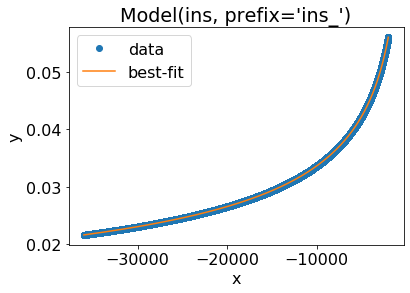

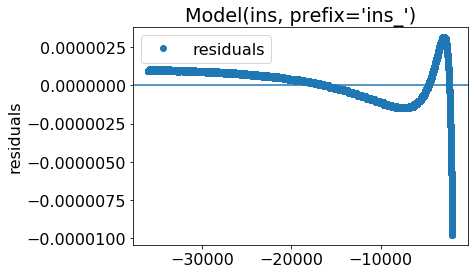

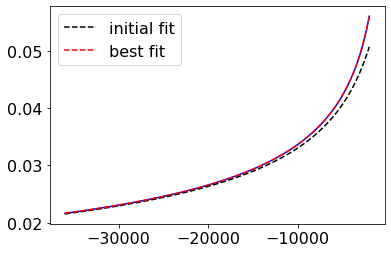

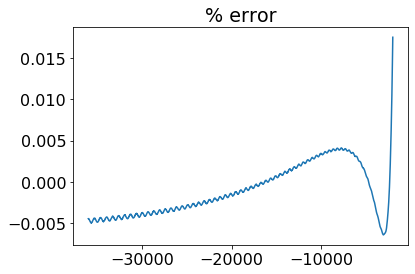

working q20.00



[[Model]]
    Model(ins, prefix='ins_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 234028
    # variables        = 4
    chi-square         = 7.8057e-06
    reduced chi-square = 3.3354e-11
    Akaike info crit   = -5645649.95
    Bayesian info crit = -5645608.50
[[Variables]]
    ins_eta:  0.04535147 (fixed)
    ins_b:    25.6106783 +/- 0.21132156 (0.83%) (init = 0)
    ins_c:   -57.6542377 +/- 0.53155369 (0.92%) (init = 0)
    ins_d:    46.2601120 +/- 0.41120108 (0.89%) (init = 0)
    ins_tc:   428.359175 +/- 7.68508346 (1.79%) (init = 40)
[[Correlations]] (unreported correlations are < 0.250)
    C(ins_c, ins_d)  = -1.000
    C(ins_b, ins_c)  = -1.000
    C(ins_b, ins_d)  =  1.000
    C(ins_b, ins_tc) =  0.999
    C(ins_c, ins_tc) = -0.999
    C(ins_d, ins_tc) =  0.999


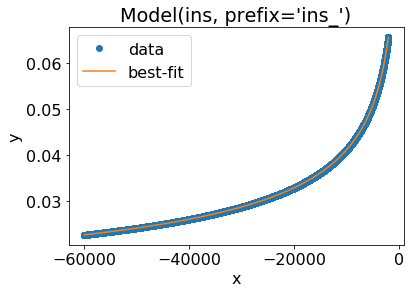

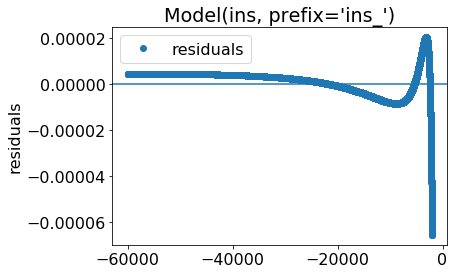

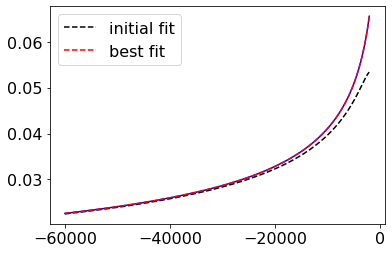

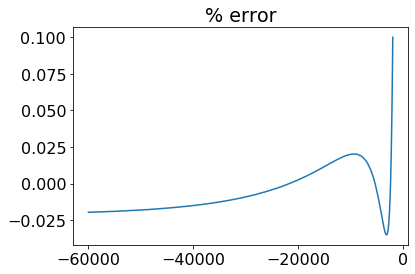

In [592]:
# k='q1'

# t1=-6000
# t1=-10000
t1=-60000
# t1=-500
# t2=60
# t2=-500
t2=-2000
# t2=-2500
# t2=-500
# t2=-3000
# t2=-10
# t2=-1000

# out = fit_ins(psi4s, k, t1, t2)

out = {}

for k in eobwfs.keys():
    print("working {}".format(k))
    print("\n\n")
    out.update({k:fit_ins(eobwfs, k, t1, t2)})
#     out.update({k:fit_ins(psi4s, k, t1, t2)})

In [593]:
out['q1.00'].result.params['ins_tc']

<Parameter 'ins_tc', value=7.453629022767633 +/- 4.52, bounds=[-inf:inf]>

In [594]:
out['q1.00'].result.params['ins_b']

<Parameter 'ins_b', value=17.55989186190989 +/- 0.571, bounds=[-inf:inf]>

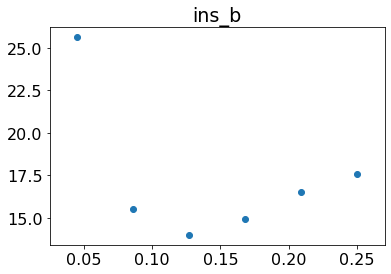

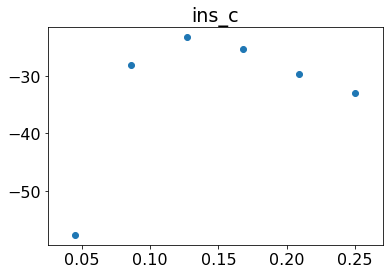

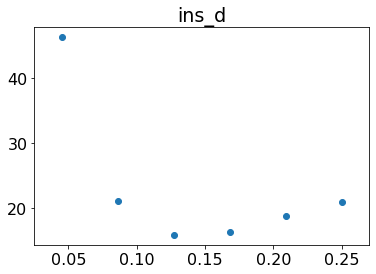

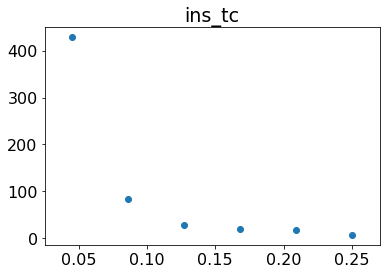

In [595]:
names = ['ins_b', 'ins_c', 'ins_d', 'ins_tc']
for name in names:
    
    plt.figure()
    x=[]
    y=[]

    for k in out.keys():
        x.append(out[k].result.params['ins_eta'].value)
        y.append(out[k].result.params[name].value)
    plt.scatter(x,y)
    plt.title(name)
    plt.show()
    plt.close()


In [596]:
ins_mod = Model(ins, prefix='ins_')

In [597]:
eobwfs.keys()

dict_keys(['q1.00', 'q2.36', 'q3.68', 'q5.69', 'q9.48', 'q20.00'])

In [598]:
eobwfs.keys()

dict_keys(['q1.00', 'q2.36', 'q3.68', 'q5.69', 'q9.48', 'q20.00'])

In [624]:
# k='q30.00'
# k='q20.00'
# k='q5.69'
k='q1.00'

In [625]:
x, y, eta = get_fit_data(eobwfs[k], t1=-3000, t2=-500)

In [626]:
bestfitparams=dict(eta=eta, tc=out[k].result.params['ins_tc'].value, b=out[k].result.params['ins_b'].value, c=out[k].result.params['ins_c'].value, d=out[k].result.params['ins_d'].value)
ybestfit=ins_mod.eval(x=x, **bestfitparams)

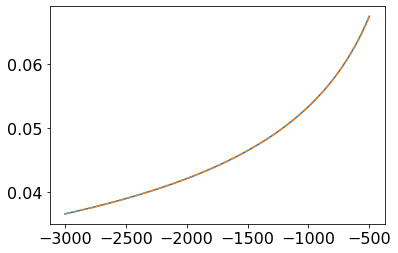

In [627]:
plt.figure()
plt.plot(x, y)
# plt.plot(x, yzero)
plt.plot(x, ybestfit, ls='--')

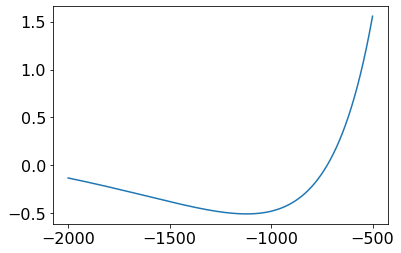

In [571]:
plt.figure()
plt.plot(x, 100*(y-ybestfit)/y)

In [539]:
# extrapolate

In [572]:
x_extrap, y_extrap, eta = get_fit_data(eobwfs[k], t1=-600000, t2=-2500)
# x_extrap, y_extrap, eta = get_fit_data(eobwfs[k], t1=-5000, t2=-500)
# x_extrap, y_extrap, eta = get_fit_data(eobwfs[k], t1=-5000, t2=-2000)

In [573]:
x_lower = np.linspace(-30000, -500, 10000)

In [574]:
bestfitparams=dict(eta=eta, tc=out[k].result.params['ins_tc'].value, b=out[k].result.params['ins_b'].value, c=out[k].result.params['ins_c'].value, d=out[k].result.params['ins_d'].value)
ybestfit_extrap=ins_mod.eval(x=x_extrap, **bestfitparams)

y_lower=ins_mod.eval(x=x_lower, **bestfitparams)

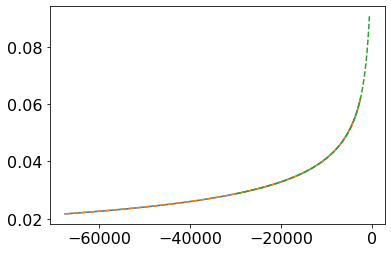

In [575]:
plt.figure()
plt.plot(x_extrap, y_extrap)
plt.plot(x_extrap, ybestfit_extrap, ls='--')
plt.plot(x_lower, y_lower, ls='--')

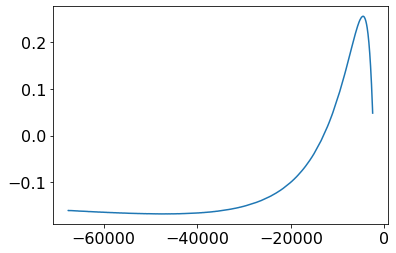

In [576]:
plt.figure()
plt.plot(x_extrap, 100*(y_extrap-ybestfit_extrap)/y_extrap)

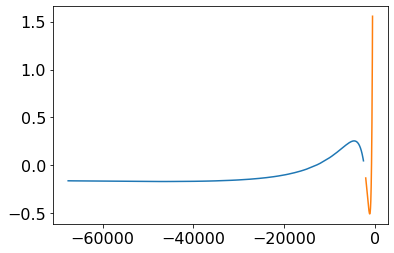

In [577]:
# compare
plt.figure()
plt.plot(x_extrap, 100*(y_extrap-ybestfit_extrap)/y_extrap)
plt.plot(x, 100*(y-ybestfit)/y)